<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#5. Extended and Unscented Kalman Filtering

This notebook replicates the figures of Chapter 5 of Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))



## 5.0 Imports

In [1]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

## 5.2 Extended Kalman Filter

First, we simulate the pendulum data using the following transition model:
\begin{align*}
  \begin{pmatrix} x_{1,k} \\ x_{2,k} \end{pmatrix} &= 
  \begin{pmatrix} x_{1,k-1} + x_{2,k-1} \Delta t \\
    x_{2,k-1} - g \sin(x_{1,k-1}) \Delta t
  \end{pmatrix} + q_{k-1} \\
  y_{k} &= \sin(x_{1,k}) + r_k \\
  y_{x_k} &= \arcsin(y_k) = \arcsin(\sin(x_{1,k}) + r_k)
\end{align*}

In [2]:
# Function to simulate pendulum
def simulate_pendulum(key, m_0, f, Q, h, r, steps):
    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)
        next_state = f(state) + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        obs = h(next_state) + jr.normal(rng2) * r
        return next_state, (next_state, obs)

    M = m_0.shape[-1]
    state = m_0
    rngs = jr.split(key, steps)
    _, (states, observations) = lax.scan(
        _step, state, rngs
    )
    return states, observations

In [3]:
# Params for pendulum simulation
key = jr.PRNGKey(0)
m_0 = jnp.array([[jnp.pi/2, 0]])
dt = 0.0125
q = 1
g = 9.8
Q = jnp.array([[q*dt**3/3, q*dt**2/2],
               [q*dt**2/2,      q*dt]])
r = 0.3
f = lambda x: jnp.array([[x[0,0] + x[0,1]*dt, x[0,1] - g*jnp.sin(x[0,0])*dt]])
h = lambda x: jnp.array([jnp.sin(x[0,0])])

# Simulate pendulum angle
states, obs = simulate_pendulum(key, m_0, f, Q, h, r, 400)

# # Apply arcsin to measured horizontal position to compute measured angle
# obs_angle = jnp.arcsin(jnp.clip(obs[:,0], -1, 1)) 

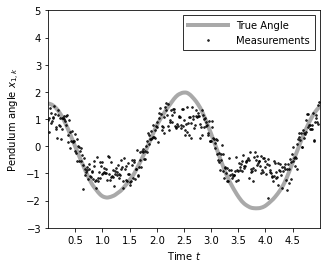

In [4]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
# plt.plot(m_kf[:,0], m_kf[:,1], color='k', linewidth=1.5, label="Filter Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Next, we use a first-order EKF to estimate the angle of pendulum from the noisy measurements.

In [5]:
# First order additive EKF
def ekf_firstorder_additive(m_0, P_0, f, F, Q, h, H, R, Y):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = f(m_k)
        P_pred = F(m_k) @ P_k @ F(m_k).T + Q

        # Update
        v = Y[t] - h(m_pred)
        S = H(m_pred) @ P_pred @ H(m_pred).T + R
        K = P_pred @ H(m_pred).T @ jnp.linalg.inv(S)
        m_post = m_pred + K @ v
        P_post = P_pred - K @ S @ K.T

        return (m_post, P_post), (m_post, P_post)
    
    num_timesteps = len(Y)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [101]:
# Additional params for EKF
F = lambda x: jnp.array([[1, dt], [-g * jnp.cos(x[0,0]) * dt, 1]])
H = lambda x: jnp.array([[jnp.cos(x[0,0]), 0]])
m_0 = jnp.array([[jnp.pi/2, 0]])
P_0 = jnp.eye(2)*0.01

# Compute EKF estimates
m_ekf, P_ekf = ekf_firstorder_additive(m_0, P_0, f, F, Q, h, H, r, obs)

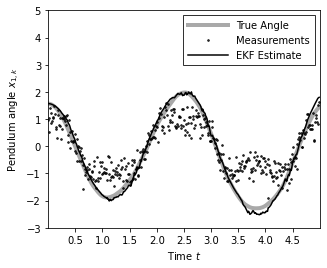

In [7]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
plt.plot(time_grid, m_ekf[:,0,0], color='k', linewidth=1.5, label="EKF Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Finally, we compute the RMSE of the EKF estimate.

In [8]:
# Helper function to compute RMSE
def compute_rmse(y, y_est):
    num_samples = y.shape[0]
    return jnp.sqrt(jnp.sum((y-y_est)**2)/num_samples)

# Compute RMSE of the EKF estimate
rmse_ekf = compute_rmse(states[:,0,0], m_ekf[:,0,0])

print(f'The RMSE of the EKF estimate of the angle is: {rmse_ekf:.2f},')
print(f'The standard deviation of measurement noise is: {jnp.sqrt(r):.2f}')

The RMSE of the EKF estimate of the angle is: 0.14,
The standard deviation of measurement noise is: 0.55


## 5.4 Statistically Linearized Filter

We use Algorithm 5.10 along with the closed-form expectations (5.70)~(5.73) to compute statistically linearized filter estimate for the simulated pendulum data.

In [10]:
# Additive SLF (Algorithm 5.10)
def slf_additive(m_0, P_0, Ef, Efdx, Q, Eh, Ehdx, R, Y):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = Ef(m_k, P_k)
        P_pred = Efdx(m_k, P_k) @ jnp.linalg.inv(P_k) @ Efdx(m_k, P_k).T + Q

        # Update step
        v = Y[t] - Eh(m_pred, P_pred)
        S = Ehdx(m_pred, P_pred) @ jnp.linalg.inv(P_pred) \
            @ Ehdx(m_pred, P_pred).T + R
        K = Ehdx(m_pred, P_pred).T @ jnp.linalg.inv(S)
        m_post = m_pred + K @ v
        P_post = P_pred - K @ S @ K.T

        return (m_post, P_post), (m_post, P_post)
    
    num_timesteps = len(Y)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [11]:
# Params for SLF
Ef = lambda m, P: jnp.array([[m[0,0]+m[0,1]*dt, 
                              m[0,1]-g*jnp.sin(m[0,0])*jnp.exp(-P[0,0]/2)*dt]])
Eh = lambda m, P: jnp.array([jnp.sin(m[0,0])*jnp.exp(-P[0,0]/2)])
c11 = lambda m, P: P[0,0] + dt*P[0,1]
c12 = lambda m, P: P[0,1] + dt*P[1,1]
c21 = lambda m, P: P[0,1] - g*dt*jnp.cos(m[0,0])*P[0,0]*jnp.exp(-P[0,0]/2)
c22 = lambda m, P: P[1,1] - g*dt*jnp.cos(m[0,0])*P[0,1]*jnp.exp(-P[0,0]/2)
Efdx = lambda m, P: jnp.array([[c11(m,P), c12(m, P)],
                               [c21(m,P), c22(m, P)]])
Ehdx = lambda m, P: jnp.array([[jnp.cos(m[0,0])*P[0,0]*jnp.exp(-P[0,0]/2),
                                jnp.cos(m[0,0])*P[0,1]*jnp.exp(-P[0,0]/2)]])

# Compute SLF estimates
m_slf, P_slf = slf_additive(m_0, P_0, Ef, Efdx, Q, Eh, Ehdx, r, obs)

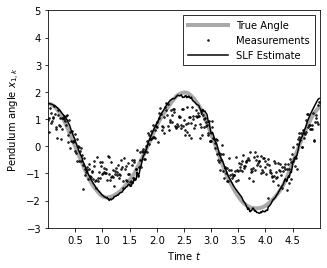

In [12]:
# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
plt.plot(time_grid, m_slf[:,0,0], color='k', linewidth=1.5, label="SLF Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Finally, we compute the RMSE of the SLF estimate.

In [13]:
# Compute RMSE of the EKF estimate
rmse_slf = compute_rmse(states[:,0,0], m_slf[:,0,0])

print(f'The RMSE of the EKF estimate of the angle is: {rmse_slf:.2f},')
print(f'The standard deviation of measurement noise is: {jnp.sqrt(r):.2f}')

The RMSE of the EKF estimate of the angle is: 0.14,
The standard deviation of measurement noise is: 0.55


## 5.6 Unscented Kalman Filter

In [185]:
# Additive UKF (Algorithm 5.14)
def ukf_additive(m_0, P_0, f, h, Q, R, alpha, beta, kappa, Y):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step:
        # 1. Form sigma points
        sigmas_pred = compute_sigmas(m_k, P_k, n, lamb)
        # 2. Propagate the sigma points
        sigmas_pred = jax.vmap(f, 0, 0)(sigmas_pred)
        # 3. Compute predicted mean and covariance
        w_mean, w_cov = compute_weights(n, alpha, beta, lamb)
        m_pred = jnp.tensordot(w_mean, sigmas_pred, axes=1)
        outer = lambda x, y: jnp.atleast_2d(x).T @ jnp.atleast_2d(y)
        outer = jax.vmap(outer, 0, 0)
        P_pred = jnp.tensordot(w_cov, 
                               outer(sigmas_pred-m_pred, sigmas_pred-m_pred), 
                               axes=1) + Q

        # Update step:
        # 1. Form sigma points
        sigmas_update = compute_sigmas(m_pred, P_pred, n, lamb)
        # 2. Propagate the sigma points
        sigmas_update = jax.vmap(h, 0, 0)(sigmas_update)
        # 3. Compute params
        mu = jnp.tensordot(w_mean, sigmas_update, axes=1)
        S = jnp.tensordot(w_cov, 
                          outer(sigmas_update-mu, sigmas_update-mu), 
                          axes=1) + r
        C = jnp.tensordot(w_cov, 
                          outer(sigmas_pred-m_pred, sigmas_update-mu), 
                          axes=1)

        # 4. Compute posterior
        K = C @ jnp.linalg.inv(S)
        m_post = m_pred + K @ (Y[t] - mu)
        P_post = P_pred - K @ S @ K.T
        
        return (m_post, P_post), (m_post, P_post)

    def compute_sigmas(m, P, n, lamb):
        disc = jnp.sqrt(n + lamb) * jnp.linalg.cholesky(P)
        sigma_plus = jnp.array([m + disc[:,i] for i in range(n)])
        sigma_minus = jnp.array([m - disc[:,i] for i in range(n)])
        return jnp.concatenate((jnp.array([m]), sigma_plus, sigma_minus))

    def compute_weights(n, alpha, beta, lamb):
        factor = 1/(2*(n+lamb))
        w_mean = jnp.concatenate((jnp.array([lamb/(n+lamb)]), 
                                  jnp.ones(2*n)*factor))
        w_cov = jnp.concatenate((jnp.array([lamb/(n+lamb) + (1-alpha**2+beta)]),
                                 jnp.ones(2*n)*factor))
        return w_mean, w_cov

    n = P_0.shape[0]
    num_timesteps = len(Y)
    lamb = alpha**2 * (n + kappa) - n
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [186]:
# Params for UKF
alpha, beta, kappa = 1, 0, 1

# Compute SLF estimates
m_ukf, P_ukf = ukf_additive(m_0, P_0, f, h, Q, r, alpha, beta, kappa, obs)

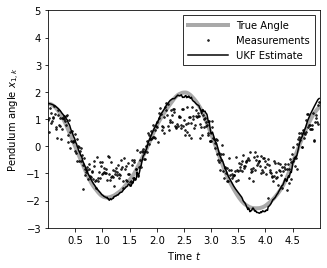

In [187]:
# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
plt.plot(time_grid, m_ukf[:,0,0], color='k', linewidth=1.5, label="UKF Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()